# Gradient Boosting and XGBoost

I will be creating models using Sklearn's Gradient Boost, and the XGBoost algorithm.

In [167]:
# Importing Required Packages.
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd
import category_encoders as ce
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix
from functions import metrics
import warnings
warnings.filterwarnings('ignore')

# Training labels
training_labels = pd.read_csv('../../Data/training_set_labels.csv', index_col='respondent_id')
training_features = pd.read_csv('../../Data/training_set_features.csv', index_col='respondent_id')

In [170]:
# TTS
X_train, X_test, y_train, y_test = train_test_split(training_features, training_labels['h1n1_vaccine'], test_size=0.33, random_state=42)

## Preproccessing
For the preproccessing, all of the columns are categorical, however, some of them are numerical, and some of them are strings. We will want to handle these these columns differently when imputing missing values.

- Numerical Categories
    - Use Sklearn's Iterative Imputer to fill in the missing values
- String Categories
    - Fill missing values with a new value: 'unknown'
    - One hot encode the results
- Categories with more then 10 unique categories
    - We will frequency code these instead, so we don't have an overwhelming amount of columns in the dataframe.

In [171]:
# Preproccessing columns
num_cols = []
ohe_cols = []
freq_cols = []

# Seperate columns into numerical, categorical, and freq

for c in training_features.columns:
    if training_features[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif training_features[c].nunique() < 10:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)


In [172]:
# Fill NaN values using IterativeImputer
num_transformer = Pipeline(steps=[
    ('num_imputer', IterativeImputer(max_iter=15)),
])

# Onehot Encoding transformer for Categorical variable
ohe_transformer = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('oh_encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Transformer for categories with more then 10 unique values
freq_transformer = Pipeline(steps=[
    ('freq_encoder', ce.count.CountEncoder(normalize=True, min_group_size=.05)),
    ('freq_imputer', SimpleImputer(strategy='constant', fill_value=0))
])


In [173]:
# Combine transformers into preprocessor.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('ohe', ohe_transformer, ohe_cols),
        ('freq', freq_transformer, freq_cols)
    ])

# Sklearn Gradient Boost
Here I will create a baseline gradient boost model to compare future models too.

In [76]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('gb_clf', GradientBoostingClassifier())
])

In [77]:
# Cross validate test
cross_validate(clf, X_train, y_train)

{'fit_time': array([6.18462467, 6.34219265, 7.08049297, 6.53098011, 5.67745829]),
 'score_time': array([0.0690763 , 0.082335  , 0.07787251, 0.06914449, 0.06008887]),
 'test_score': array([0.85331098, 0.84772283, 0.85219335, 0.85159307, 0.8529905 ])}

In [78]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score
clf.fit(X_train, y_train)
_preds = clf.predict(X_test)

metrics(y_test, _preds)

accuracy: 0.854
recall: 0.486
f1: 0.585
roc_auc: 0.719


With Objects:

accuracy: 0.854
recall: 0.486
f1: 0.585
roc_auc: 0.719

## XGBoost
Let's try a baseline model for XGBoost as well.


In [79]:
XG_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('gb_clf', XGBClassifier(eval_metric='auc'))
])


In [80]:
cross_validate(XG_clf, X_train, y_train)

{'fit_time': array([4.25926065, 4.32036829, 4.34091234, 4.33380318, 3.87927485]),
 'score_time': array([0.07836843, 0.07836819, 0.07539225, 0.07936025, 0.07539177]),
 'test_score': array([0.85079631, 0.84353171, 0.84353171, 0.84041364, 0.84684181])}

In [81]:
XG_clf.fit(X_train, y_train)
boost_preds = XG_clf.predict(X_test)
metrics(y_test, boost_preds)

accuracy: 0.845
recall: 0.513
f1: 0.584
roc_auc: 0.724


# Catboost
Finally, since all of our data is categorical, I'd like to try catboost as well.

In [82]:
cat_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('catboost_clf', CatBoostClassifier(task_type='GPU'))
])

In [83]:
cat_clf.fit(X_train, y_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.028766
0:	learn: 0.6701202	total: 54ms	remaining: 53.9s
1:	learn: 0.6481042	total: 97.9ms	remaining: 48.9s
2:	learn: 0.6282114	total: 146ms	remaining: 48.4s
3:	learn: 0.6096395	total: 189ms	remaining: 47.2s
4:	learn: 0.5925618	total: 229ms	remaining: 45.6s
5:	learn: 0.5767983	total: 263ms	remaining: 43.6s
6:	learn: 0.5621145	total: 299ms	remaining: 42.4s
7:	learn: 0.5485969	total: 340ms	remaining: 42.1s
8:	learn: 0.5361738	total: 375ms	remaining: 41.3s
9:	learn: 0.5243772	total: 409ms	remaining: 40.5s
10:	learn: 0.5129884	total: 446ms	remaining: 40.1s
11:	learn: 0.5034961	total: 480ms	remaining: 39.5s
12:	learn: 0.4935413	total: 515ms	remaining: 39.1s
13:	learn: 0.4847750	total: 554ms	remaining: 39s
14:	learn: 0.4765381	total: 594ms	remaining: 39s
15:	learn: 0.4689992	total: 626ms	remaining: 38.5s
16:	learn: 0.4621276	total: 657ms	remaining: 38s
17:	learn: 0.4557646	total: 692ms	remaining: 37.7s
18:	learn: 0.4496457	total: 728ms	remaining: 37.6s
19:	learn: 0.4439

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                 

In [84]:
metrics(y_test, cat_clf.predict(X_test))

accuracy: 0.853
recall: 0.498
f1: 0.590
roc_auc: 0.723


Catboost did about as well as XGboost did, but the biggest thing I noticed is that it took 1/4 of the amount of time to train. I think this would be a much better model type to use going forward.

## Catboost Tuning

In [85]:
# Create pipleline with tuned params
tuned_cat_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # Changing the eval metric from "logloss" to "AUC" and modifying the learning rate
    ('catboost_clf', CatBoostClassifier(learning_rate=0.03,
    eval_metric='AUC', task_type='GPU'))
])

In [86]:
# Fit the new model
tuned_cat_clf.fit(X_train, y_train)

0:	learn: 0.8362622	total: 40.1ms	remaining: 40s
1:	learn: 0.8429240	total: 79.2ms	remaining: 39.5s
2:	learn: 0.8454295	total: 119ms	remaining: 39.4s
3:	learn: 0.8467833	total: 158ms	remaining: 39.4s
4:	learn: 0.8469359	total: 194ms	remaining: 38.6s
5:	learn: 0.8475717	total: 230ms	remaining: 38.2s
6:	learn: 0.8478817	total: 268ms	remaining: 38s
7:	learn: 0.8475021	total: 311ms	remaining: 38.5s
8:	learn: 0.8475730	total: 353ms	remaining: 38.9s
9:	learn: 0.8482671	total: 391ms	remaining: 38.7s
10:	learn: 0.8498571	total: 429ms	remaining: 38.5s
11:	learn: 0.8498525	total: 464ms	remaining: 38.2s
12:	learn: 0.8501118	total: 501ms	remaining: 38s
13:	learn: 0.8498805	total: 544ms	remaining: 38.3s
14:	learn: 0.8495913	total: 579ms	remaining: 38s
15:	learn: 0.8502429	total: 613ms	remaining: 37.7s
16:	learn: 0.8500830	total: 651ms	remaining: 37.6s
17:	learn: 0.8504451	total: 687ms	remaining: 37.5s
18:	learn: 0.8515907	total: 725ms	remaining: 37.4s
19:	learn: 0.8518794	total: 770ms	remaining: 37

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                 

In [87]:
# Calculate metrics
metrics(y_test, tuned_cat_clf.predict(X_test))

accuracy: 0.853
recall: 0.498
f1: 0.590
roc_auc: 0.723


## More Tuned Catboost

In [116]:
tuned_cat_clf2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # For these parameters, I selected many common hypertuning parameters and gave them a generic value
    ('catboost_clf2', CatBoostClassifier(eval_metric='AUC', task_type='GPU', iterations=500,
                                         random_strength=5,
                                         bagging_temperature=5,
                                         max_bin=5,
                                         grow_policy='Lossguide',
                                         min_data_in_leaf=5,
                                         max_depth=5,
                                         l2_leaf_reg=10,
                                         auto_class_weights='Balanced'))
])



In [117]:
tuned_cat_clf2.fit(X_train, y_train)

0:	learn: 0.8138077	total: 15.5ms	remaining: 7.71s
1:	learn: 0.8314086	total: 29ms	remaining: 7.21s
2:	learn: 0.8371944	total: 43.1ms	remaining: 7.14s
3:	learn: 0.8421153	total: 56.6ms	remaining: 7.02s
4:	learn: 0.8414020	total: 70.4ms	remaining: 6.97s
5:	learn: 0.8428516	total: 84.1ms	remaining: 6.92s
6:	learn: 0.8452910	total: 97.6ms	remaining: 6.87s
7:	learn: 0.8479708	total: 112ms	remaining: 6.87s
8:	learn: 0.8485084	total: 125ms	remaining: 6.81s
9:	learn: 0.8479064	total: 138ms	remaining: 6.74s
10:	learn: 0.8484875	total: 151ms	remaining: 6.71s
11:	learn: 0.8478840	total: 164ms	remaining: 6.68s
12:	learn: 0.8481676	total: 178ms	remaining: 6.67s
13:	learn: 0.8483166	total: 192ms	remaining: 6.66s
14:	learn: 0.8500961	total: 204ms	remaining: 6.59s
15:	learn: 0.8506159	total: 217ms	remaining: 6.58s
16:	learn: 0.8504891	total: 230ms	remaining: 6.54s
17:	learn: 0.8514361	total: 244ms	remaining: 6.52s
18:	learn: 0.8514309	total: 258ms	remaining: 6.52s
19:	learn: 0.8521027	total: 274ms	re

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                 

In [118]:
metrics(y_test, tuned_cat_clf2.predict(X_test))

accuracy: 0.804
recall: 0.741
f1: 0.616
roc_auc: 0.781


### Conclusion:
Just from manually adding some parameters and tuning them by hand, we have a significant increase to our metrics.

## Catboost Tuning: Min Trees/Max_leaves

In [194]:
tuned_cat_clf3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # For these parameters, I selected many common hypertuning parameters and gave them a generic value
    ('catboost_clf3', CatBoostClassifier(eval_metric='AUC', iterations=500,
                                         loss_function='Logloss',
                                         random_strength=4,
                                         bagging_temperature=3,
                                         max_bin=5,
                                         grow_policy='Lossguide',
                                         min_data_in_leaf=5,
                                         max_depth=5,
                                         l2_leaf_reg=300,
                                         auto_class_weights='Balanced',
                                         best_model_min_trees=3,
                                         max_leaves=30
                                         ))
])



In [195]:
tuned_cat_clf3.fit(X_train, y_train)

0:	total: 28.5ms	remaining: 14.2s
1:	total: 57.4ms	remaining: 14.3s
2:	total: 91ms	remaining: 15.1s
3:	total: 135ms	remaining: 16.8s
4:	total: 192ms	remaining: 19s
5:	total: 223ms	remaining: 18.4s
6:	total: 269ms	remaining: 18.9s
7:	total: 292ms	remaining: 18s
8:	total: 335ms	remaining: 18.3s
9:	total: 358ms	remaining: 17.6s
10:	total: 378ms	remaining: 16.8s
11:	total: 401ms	remaining: 16.3s
12:	total: 429ms	remaining: 16.1s
13:	total: 451ms	remaining: 15.6s
14:	total: 487ms	remaining: 15.7s
15:	total: 536ms	remaining: 16.2s
16:	total: 570ms	remaining: 16.2s
17:	total: 590ms	remaining: 15.8s
18:	total: 614ms	remaining: 15.6s
19:	total: 647ms	remaining: 15.5s
20:	total: 670ms	remaining: 15.3s
21:	total: 733ms	remaining: 15.9s
22:	total: 755ms	remaining: 15.7s
23:	total: 772ms	remaining: 15.3s
24:	total: 793ms	remaining: 15.1s
25:	total: 827ms	remaining: 15.1s
26:	total: 849ms	remaining: 14.9s
27:	total: 863ms	remaining: 14.6s
28:	total: 883ms	remaining: 14.3s
29:	total: 904ms	remaining:

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                 

In [196]:
metrics(training_labels['h1n1_vaccine'], tuned_cat_clf3.predict(training_features))

accuracy: 0.808
recall: 0.781
f1: 0.634
roc_auc: 0.799


# CatBoost Final Tweaks
I'm going to play around with my current parameter's values, and see if I can get something better

In [162]:
tuned_cat_clf4 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # For these parameters, I selected many common hypertuning parameters and gave them a generic value
    ('catboost_clf3', CatBoostClassifier(eval_metric='AUC', task_type='GPU', iterations=500,
                                         loss_function='Logloss',
                                         max_bin=5,
                                         grow_policy='Lossguide',
                                         min_data_in_leaf=5,
                                         max_depth=5,
                                         l2_leaf_reg=300,
                                         auto_class_weights='Balanced',
                                         best_model_min_trees=3,
                                         max_leaves=30
                                         ))
])

tuned_cat_4_params= {
    'catboost_clf3__random_strength': [3, 4, 5, 6, 7],
    'catboost_clf3__bagging_temperature': [3, 4, 5, 6, 7]
}
cat_grid_clf = GridSearchCV(tuned_cat_clf4, param_grid=tuned_cat_4_params, scoring='roc_auc')

cat_output = cat_grid_clf.fit(X_train, y_train)




Custom logger is already specified. Specify more than one logger at same time is not thread safe.

KeyboardInterrupt: 

In [219]:
cat_grid_clf.best_params_

{'catboost_clf3__bagging_temperature': 3, 'catboost_clf3__random_strength': 4}

In [220]:
metrics(y_test, cat_grid_clf.predict(X_test))

accuracy: 0.805
recall: 0.741
f1: 0.617
roc_auc: 0.781


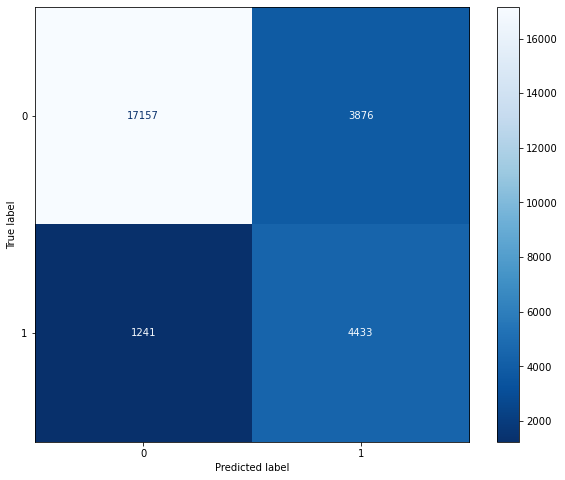

In [207]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(tuned_cat_clf3, training_features, training_labels['h1n1_vaccine'], cmap='Blues_r', ax=ax);

## Gridsearch XGBoost Models
### Max_Depth

In [62]:
XG_params = {
    'gb_clf__max_depth': [1, 2, 3, 4, 5]
}
XG_grid_clf = GridSearchCV(XG_clf, param_grid=XG_params, scoring='f1')
output = XG_grid_clf.fit(X_train, y_train)

NameError: name 'XG_clf' is not defined

In [59]:
metrics(y_test, XG_grid_clf.predict(X_test))

accuracy: 0.853
recall: 0.510
f1: 0.596
roc_auc: 0.728


Just an initial Gridsearch to check
   - The time needed to run
   - How much the F1 score will increase

I've noted that it takes a VERY long time to run gridsearch with XGBoost, so in the interest of time, I'm going to perform less exhaustive grid searches.

## Learning Rate

In [60]:
XG_params_lr = {
    'gb_clf__max_depth': [3],
    'gb_clf__learning_rate': [0.1, 0.3, 0.5, 0.7]
}
XG_grid_clf_lr = GridSearchCV(XG_clf, param_grid=XG_params_lr, scoring='f1')
output = XG_grid_clf_lr.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
print(output.best_params_)
metrics(y_test, XG_grid_clf_lr.predict(X_test))

## Min Split loss

In [ ]:
XG_params_msl = {
    'gb_clf__max_depth': [3],
    'gb_clf__learning_rate': [0.5],
    'gb_clf__min_split_loss': [0, 5, 10]
}
XG_grid_clf_msl = GridSearchCV(XG_clf, param_grid=XG_params_msl, scoring='f1')
output = XG_grid_clf_msl.fit(X_train, y_train)
print(output.best_params_)
metrics(y_test, XG_grid_clf_msl.predict(X_test))